# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by an other algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some ways to compare two given distributions $p_D$ and $p_\theta$?**

> * Kullback-Leibler Divergence: $D_{KL} (p_D \| p_\theta) = -\sum_{x \in \mathcal{X}} p_D (x) \log \Big ( \cfrac{p_\theta (x)}{p_D (x)} \Big )$

> * Cross Entropy: $H(p_D, p_\theta) = -\sum_{x \in \mathcal{X}} p_D(x) \log p_\theta (x)$

> * Kolmogorov–Smirnov Statistic: Given $F_D$ the empirical distribution function of $p_D$, $F_\theta$ the empirical distribution function of $p_\theta$, we have $D (F_D, F_\theta) = \sup_{x \in \mathcal{X}} |F_D(x) - F_\theta(x) |$

> * Jensen-Shannon Divergence: a symmetrized and smoothed version of the Kullback–Leibler divergence. It is defined as $JSD(p_D \| p_\theta) = \cfrac{1}{2} \Big(D_{KL} (p_D \| p_M) + D_{KL} (p_\theta \| p_M) \Big)$ with $p_M = \cfrac{1}{2} \Big(p_D + p_\theta \Big)$

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them directly.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> **Comparaison from distribution**: We need to have a distribution explicitly.

> **Comparaison from sampled values**: We need to have a method (discriminator) to decide whether we reject a sample or not.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strenghts and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimentional gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise?**

> As my opinion, the dimension of the input noise influences the complexity of the generator. If $N$ is large, the input space is large thus it has more variations. It is prefered mostly in such tasks needing high resolution outputs. However, the neural network is more difficult to train in order to have a good generating ability,

By construction, this generator structure only allows sampling of the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$. Such a model seems to need a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to differentiate examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator (whose output is denoted by $D(x)$) is trained using a classic discrimination loss, so that $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$

So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the JSD between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> The vanishing gradients appear when the data distribution and model distribution are in a non-overlapping
lower dimensional manifold. In such a case the discriminator can be trained to perfection leading to
vanishing gradients. Under the assumption of infinite capacity of the models, the JSD saturates.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what can this imply?**

> This implies that the generator does not change the distributions of the $p_D$. It focus only on generating images from random noises which can cheat the discriminator. 

>As an assumption, each time when we train the generator, we assume that the discriminator can do a good job.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be 25 Gaussian distributions with small variance, distributed on a $5\times 5$ grid.

In [1]:
import torch

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the 25-gaussian dataset.
    
    return a torch tensor of dimensions (batchlen, 2)
    """
    # to sample from the gaussian mixture, we first sample the means for each point, then
    # add a gaussian noise with small variance
    samples = torch.multinomial(torch.tensor([0.2,0.2,0.2,0.2,0.2]), 2*batchlen, replacement=True)
    means = (2.0 * (samples - 2.0)).view(batchlen,2).type(torch.FloatTensor)
    return torch.normal(means, 0.05)

Let's plot a batch, to see what the dataset looks like.

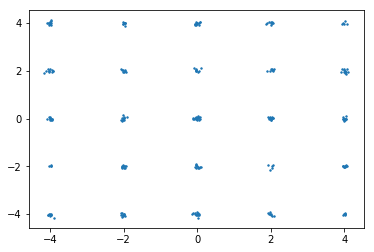

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(256)

plt.scatter(batch[:,0], batch[:,1], s=2.0, label='Batch of data from our gaussian mixture dataset')
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

When representing a binary classifier with a neural network, it is better for the last layer to consist of only a sigmoid activation, so that the output values will be between 0 and 1 and stand for the probability (according to the classifier) that the input is of the first class. The output is thus of the form $\mathrm{sigmoid}(h)$. The loss involves quantities such as $-\log(\mathrm{sigmoid}(h))$. For numerical stability reasons, it is recommended to rewrite the loss in order to make use of the $\mathrm{softplus}$ function defined by $\mathrm{softplus}(h) = \log(1 + \exp(h))$ and provided in PyTorch as `torch.softplus`.
As the $\mathrm{softplus}(h)$ formulation of the loss already contains the sigmoid activation, in practice the last layer of the discrimator network will not have any activation function (being just $h$).

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 50

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 2)
        
    def __call__(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return self.fc3(h)
    
    def generate(self, batchlen, use_cuda):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        if use_cuda:
            z = z.cuda()
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 1)
    
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

With these classes in shape, only the training loop is still missing. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, its gradient will vanish (as seen in **Q4**) and thus no information will be passed to the generator.

We will then train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 7.668e+01, generator: 6.643e+02


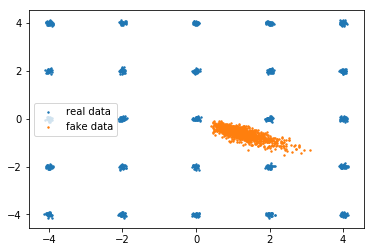

step 1000: discriminator: 3.549e+02, generator: 1.781e+02


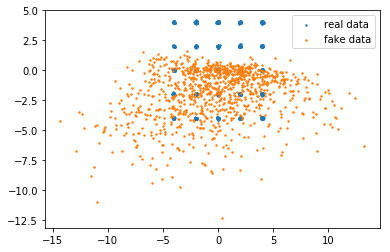

step 2000: discriminator: 3.549e+02, generator: 1.780e+02


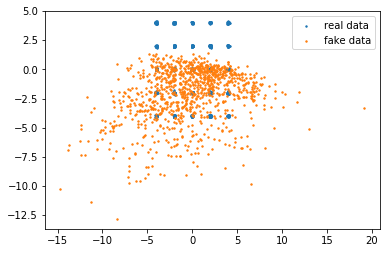

step 3000: discriminator: 3.549e+02, generator: 1.778e+02


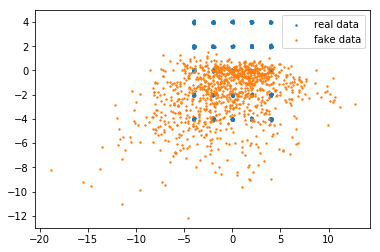

step 4000: discriminator: 3.549e+02, generator: 1.780e+02


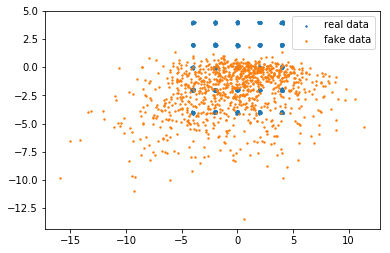

step 5000: discriminator: 3.549e+02, generator: 1.781e+02


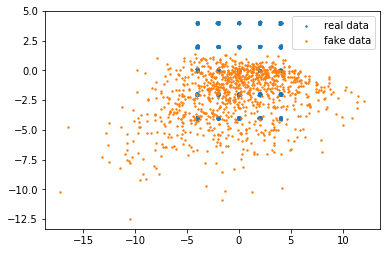

step 6000: discriminator: 3.549e+02, generator: 1.778e+02


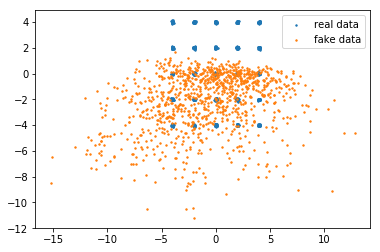

step 7000: discriminator: 3.549e+02, generator: 1.775e+02


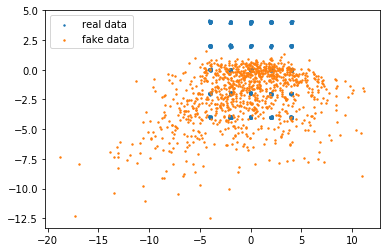

step 8000: discriminator: 3.549e+02, generator: 1.770e+02


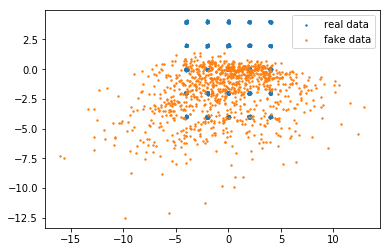

step 9000: discriminator: 3.549e+02, generator: 1.770e+02


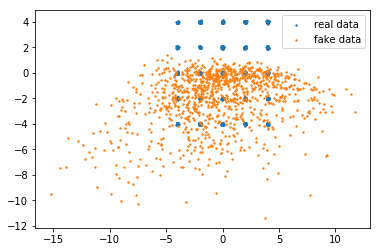

step 10000: discriminator: 3.549e+02, generator: 1.785e+02


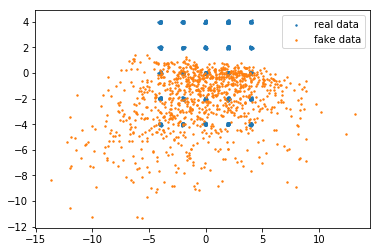

step 11000: discriminator: 3.549e+02, generator: 1.783e+02


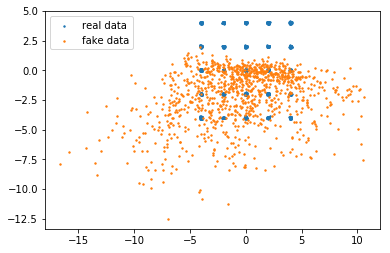

step 12000: discriminator: 3.549e+02, generator: 1.791e+02


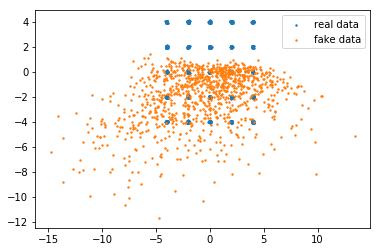

step 13000: discriminator: 3.549e+02, generator: 1.758e+02


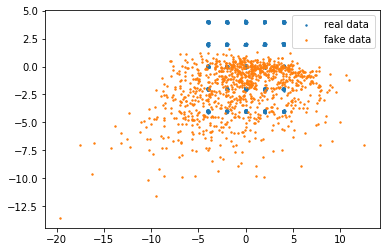

step 14000: discriminator: 3.549e+02, generator: 1.762e+02


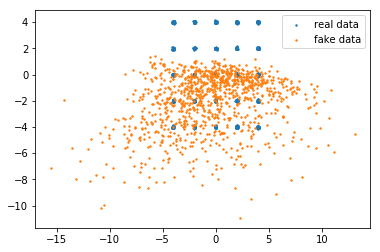

step 15000: discriminator: 3.549e+02, generator: 1.766e+02


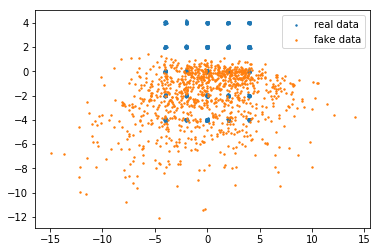

step 16000: discriminator: 3.549e+02, generator: 1.756e+02


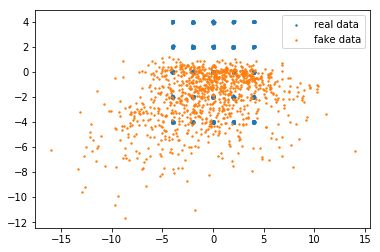

step 17000: discriminator: 3.549e+02, generator: 1.768e+02


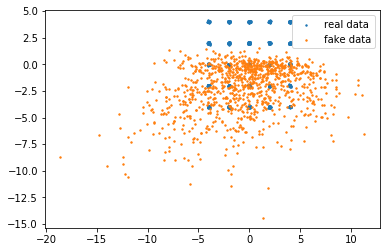

step 18000: discriminator: 3.549e+02, generator: 1.769e+02


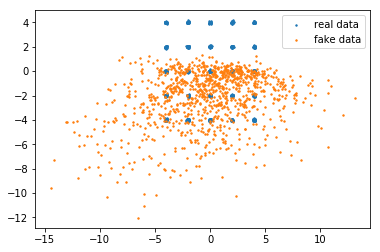

step 19000: discriminator: 3.549e+02, generator: 1.772e+02


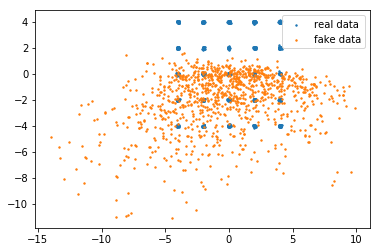

step 20000: discriminator: 3.549e+02, generator: 1.783e+02


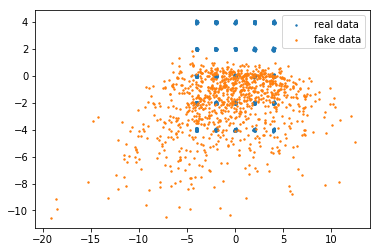

step 21000: discriminator: 3.549e+02, generator: 1.781e+02


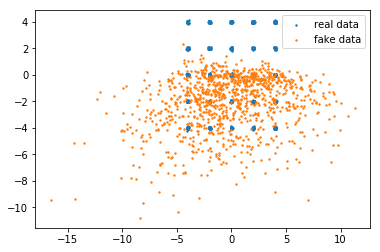

step 22000: discriminator: 3.549e+02, generator: 1.789e+02


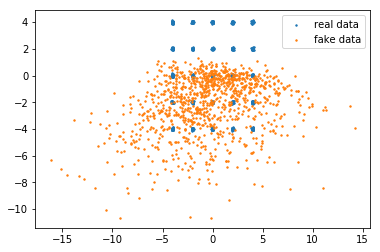

step 23000: discriminator: 3.549e+02, generator: 1.756e+02


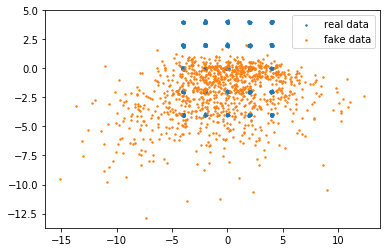

step 24000: discriminator: 3.549e+02, generator: 1.760e+02


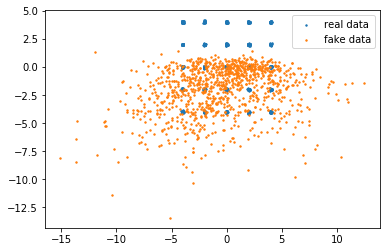

step 25000: discriminator: 3.549e+02, generator: 1.769e+02


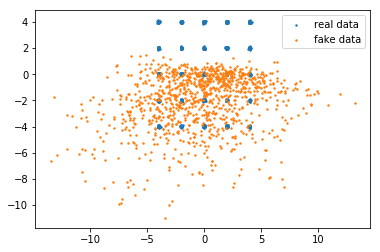

step 26000: discriminator: 3.549e+02, generator: 1.792e+02


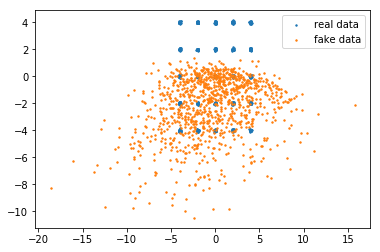

step 27000: discriminator: 3.549e+02, generator: 1.765e+02


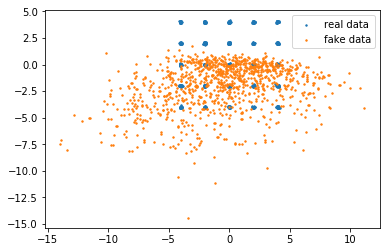

step 28000: discriminator: 3.549e+02, generator: 1.780e+02


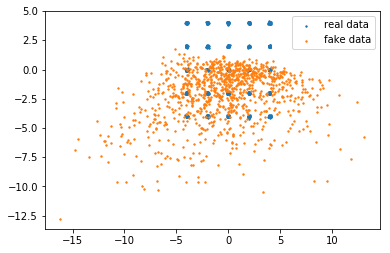

step 29000: discriminator: 3.549e+02, generator: 1.785e+02


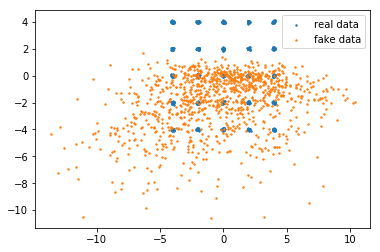

step 30000: discriminator: 3.549e+02, generator: 1.779e+02


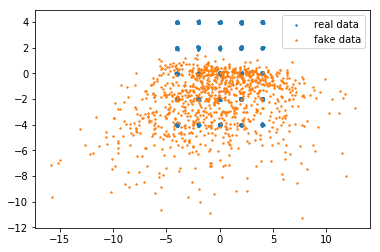

step 31000: discriminator: 3.549e+02, generator: 1.755e+02


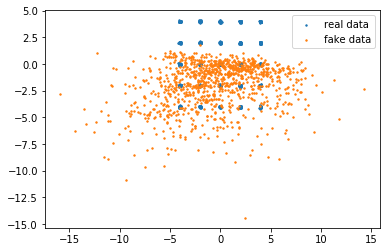

step 32000: discriminator: 3.549e+02, generator: 1.784e+02


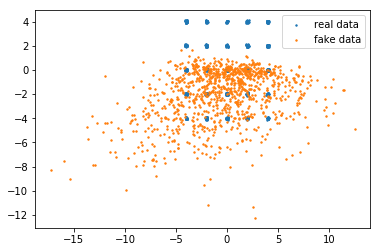

step 33000: discriminator: 3.549e+02, generator: 1.769e+02


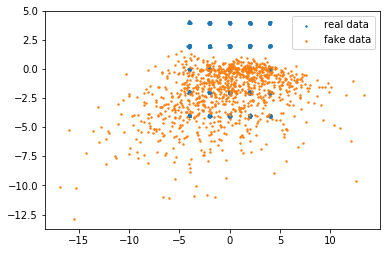

step 34000: discriminator: 3.549e+02, generator: 1.766e+02


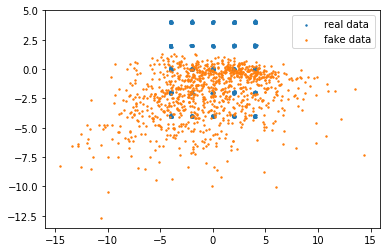

step 35000: discriminator: 3.549e+02, generator: 1.769e+02


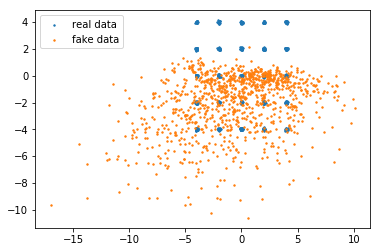

step 36000: discriminator: 3.549e+02, generator: 1.769e+02


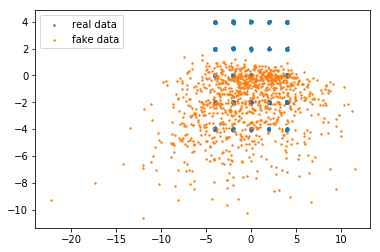

step 37000: discriminator: 3.549e+02, generator: 1.778e+02


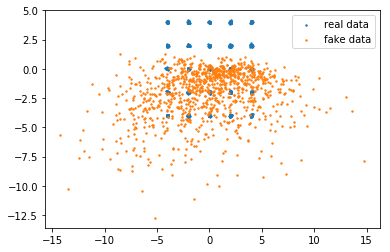

step 38000: discriminator: 3.549e+02, generator: 1.768e+02


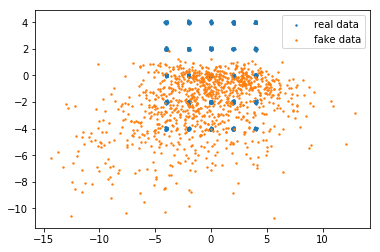

step 39000: discriminator: 3.549e+02, generator: 1.792e+02


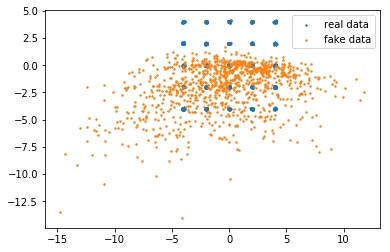

step 40000: discriminator: 3.549e+02, generator: 1.770e+02


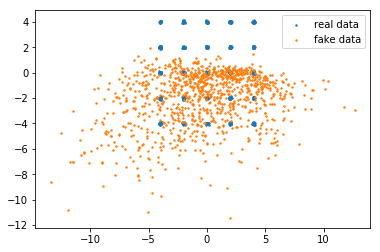

step 41000: discriminator: 3.549e+02, generator: 1.795e+02


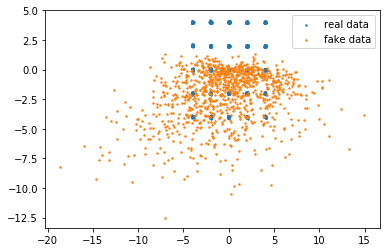

step 42000: discriminator: 3.549e+02, generator: 1.768e+02


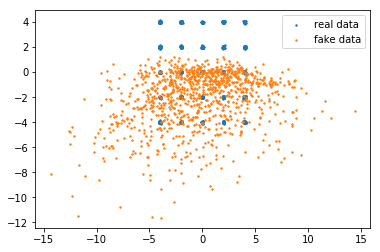

step 43000: discriminator: 3.549e+02, generator: 1.768e+02


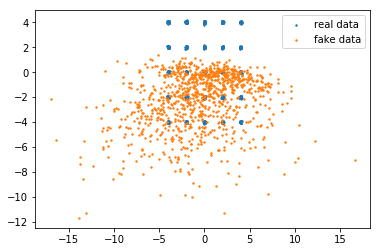

step 44000: discriminator: 3.549e+02, generator: 1.792e+02


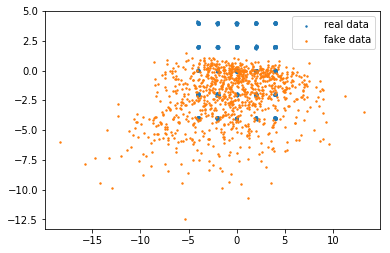

step 45000: discriminator: 3.549e+02, generator: 1.755e+02


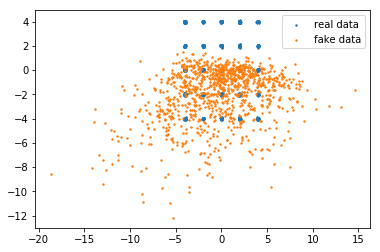

step 46000: discriminator: 3.549e+02, generator: 1.772e+02


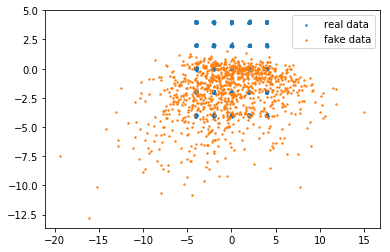

step 47000: discriminator: 3.549e+02, generator: 1.781e+02


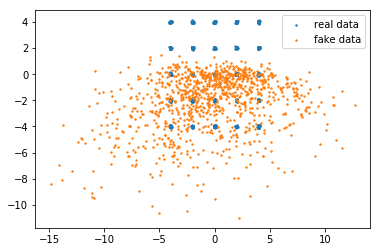

step 48000: discriminator: 3.549e+02, generator: 1.760e+02


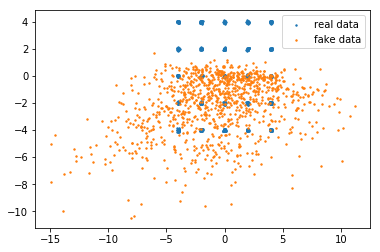

step 49000: discriminator: 3.549e+02, generator: 1.768e+02


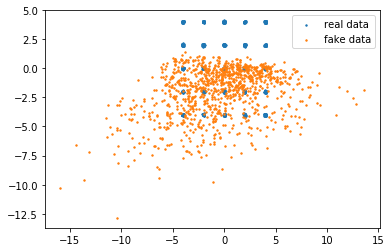

step 50000: discriminator: 3.549e+02, generator: 1.755e+02


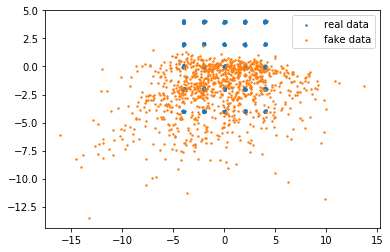

step 51000: discriminator: 3.549e+02, generator: 1.779e+02


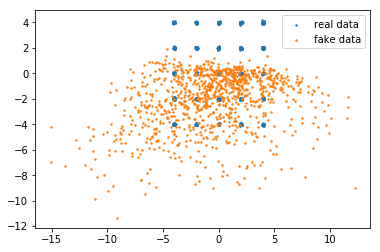

step 52000: discriminator: 3.549e+02, generator: 1.776e+02


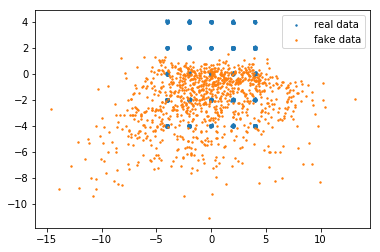

step 53000: discriminator: 3.549e+02, generator: 1.765e+02


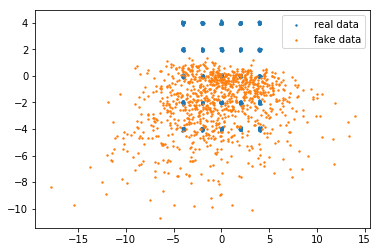

step 54000: discriminator: 3.549e+02, generator: 1.753e+02


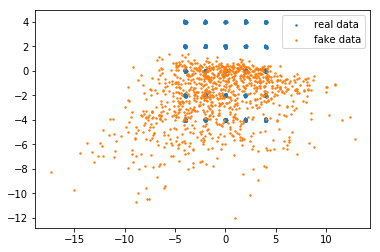

step 55000: discriminator: 3.549e+02, generator: 1.784e+02


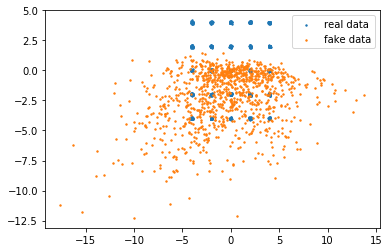

step 56000: discriminator: 3.549e+02, generator: 1.778e+02


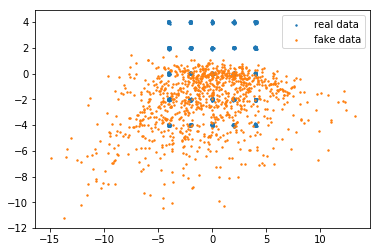

step 57000: discriminator: 3.549e+02, generator: 1.789e+02


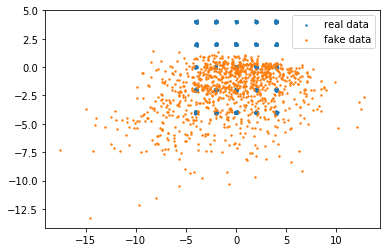

step 58000: discriminator: 3.549e+02, generator: 1.765e+02


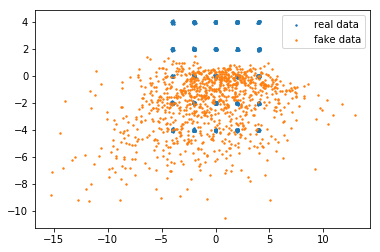

step 59000: discriminator: 3.549e+02, generator: 1.756e+02


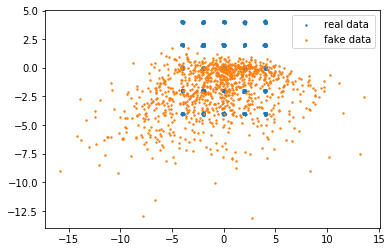

step 60000: discriminator: 3.549e+02, generator: 1.784e+02


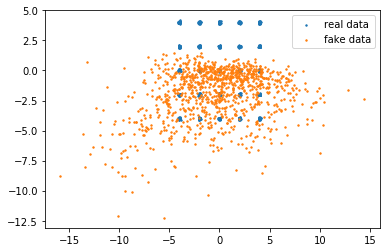

step 61000: discriminator: 3.549e+02, generator: 1.775e+02


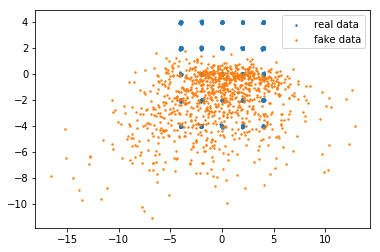

step 62000: discriminator: 3.549e+02, generator: 1.772e+02


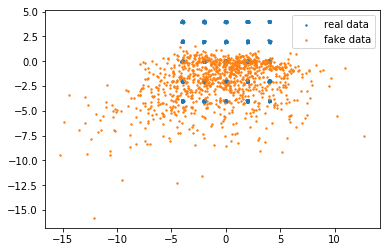

step 63000: discriminator: 3.549e+02, generator: 1.793e+02


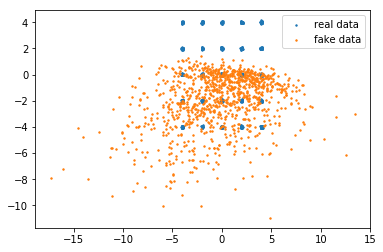

step 64000: discriminator: 3.549e+02, generator: 1.794e+02


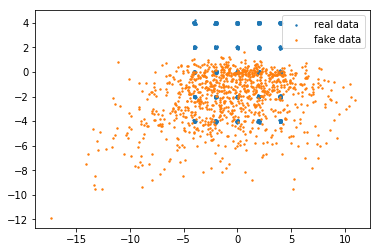

step 65000: discriminator: 3.549e+02, generator: 1.768e+02


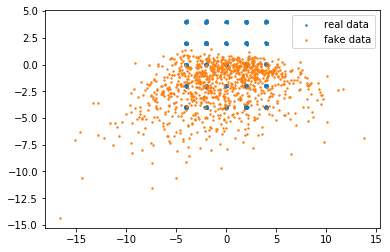

step 66000: discriminator: 3.549e+02, generator: 1.770e+02


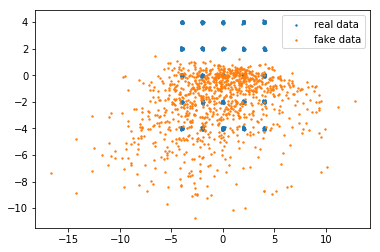

step 67000: discriminator: 3.549e+02, generator: 1.768e+02


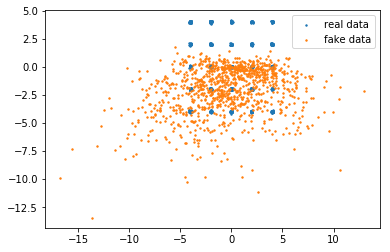

step 68000: discriminator: 3.549e+02, generator: 1.791e+02


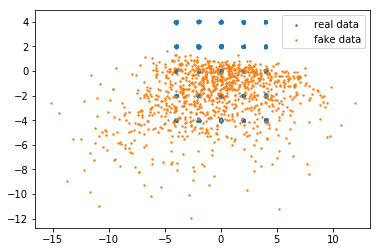

step 69000: discriminator: 3.549e+02, generator: 1.782e+02


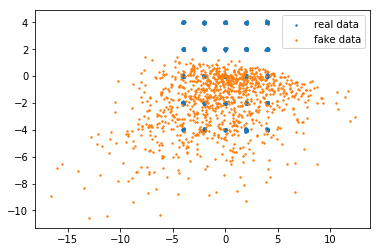

step 70000: discriminator: 3.549e+02, generator: 1.763e+02


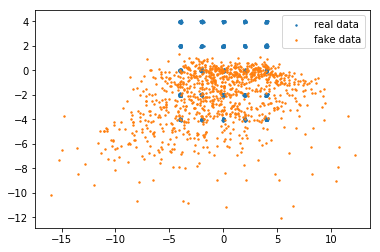

step 71000: discriminator: 3.549e+02, generator: 1.774e+02


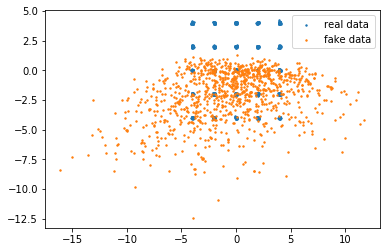

step 72000: discriminator: 3.549e+02, generator: 1.776e+02


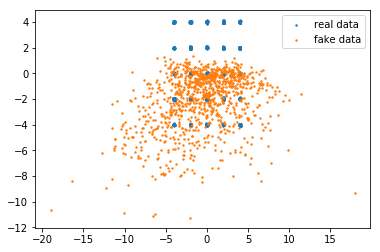

step 73000: discriminator: 3.549e+02, generator: 1.786e+02


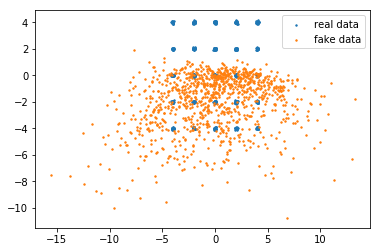

step 74000: discriminator: 3.549e+02, generator: 1.790e+02


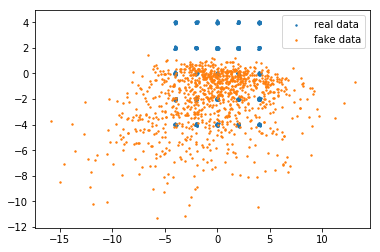

step 75000: discriminator: 3.549e+02, generator: 1.754e+02


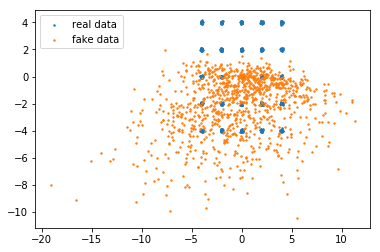

step 76000: discriminator: 3.549e+02, generator: 1.773e+02


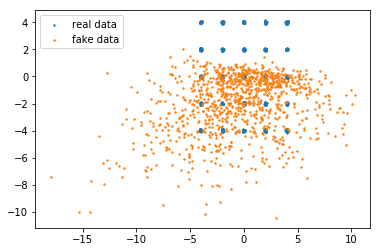

step 77000: discriminator: 3.549e+02, generator: 1.782e+02


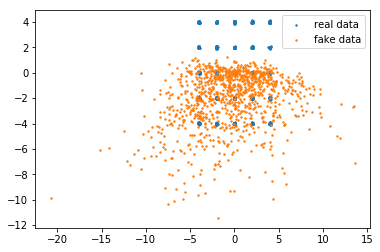

step 78000: discriminator: 3.549e+02, generator: 1.784e+02


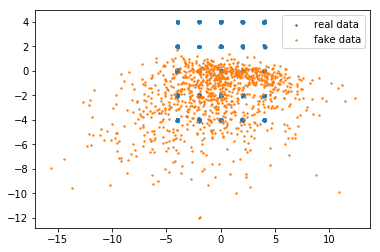

step 79000: discriminator: 3.549e+02, generator: 1.766e+02


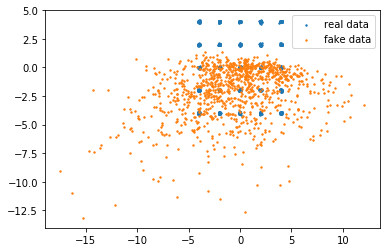

step 80000: discriminator: 3.549e+02, generator: 1.783e+02


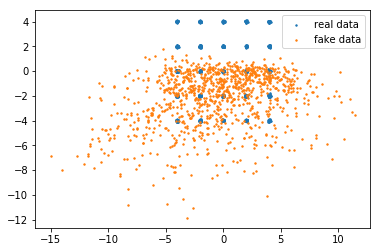

In [7]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 5
# Total number of training iterations for the generator
N_ITER = 80001
# Batch size to use
BATCHLEN = 256

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr = 0.05, betas = (0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr = 0.05, betas = (0.5,0.9))

#use_cuda = torch.cuda.is_available()
use_cuda = False

if use_cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()


for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN, use_cuda)
        if use_cuda:
            real_batch = real_batch.cuda()
            fake_batch = fake_batch.cuda()
        # Compute here the discriminator loss, using functions like torch.sum, torch.exp, torch.log,
        # torch.softplus, using real_batch and fake_batch
        real_pred = discriminator(real_batch)
        fake_pred = discriminator(fake_batch)
        real_loss = torch.sum(F.softplus(-real_pred))
        fake_loss = torch.sum(F.softplus(-fake_pred) + fake_pred)
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN, use_cuda)
    if use_cuda:
        fake_batch = fake_batch.cuda()
    # Compute here the generator loss, using fake_batch
    fake_pred = discriminator(fake_batch)
    #gen_loss = torch.sum(fake_pred + F.softplus(-ake_pred))
    gen_loss = torch.sum(F.softplus(-fake_pred))
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024, use_cuda).detach()
        plt.scatter(real_batch[:,0].cpu(), real_batch[:,1].cpu(), s=2.0, label='real data')
        plt.scatter(fake_batch[:,0].cpu(), fake_batch[:,1].cpu(), s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> When we use the above generator's loss, we assume that the generator should generate fake samples, which does not correspond to our expectation. 

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

> **Depth / Width of the generator network**: If the network is more complicated, the distortion of the input noise is larger, thus it can generate more examples.

> **Depth / Width of the discriminator network**: If the discriminator network is more complicated, it can distinguish hard exmaples, but we should make sure that it does not overfit the data.

> **Impact of TRAIN_RATIO**: It is difficult to say the impact of train_ratio. In some literatures, they proposed to use train_ratio = 1. But some researchers tested out a ratio of 5 discriminator iterations per generator update.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

An other well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \log p_\theta(x)$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.

**Q8: Prove this equivalence.**

> $\mathbb{E}_{p_D} \log p_\theta(x) = \sum_{x \in \mathcal{X}} p_D \log p_\theta (x)$

> $D_{KL} (p_D \| p_\theta) = -\sum_{x \in \mathcal{X}} p_D (x) \log \Big ( \cfrac{p_\theta (x)}{p_D (x)} \Big ) = -\sum_{x \in \mathcal{X}} p_D (x) \log p_\theta (x) + \sum_{x \in \mathcal{X}} p_D (x) \log p_D (x) = -\sum_{x \in \mathcal{X}} p_D (x) \log  p_\theta (x) + const$ 

> Thus maximize $\mathbb{E}_{p_D} \log p_\theta(x)$ is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$

However, the class of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution like so: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Where here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)ds$ is an infinite mixture of gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce an other, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} - \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms form a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> The distribution of $p(z)$ is an assumption we made before the training process. A common choice is $\mathcal{N} (0, 1)$ since it facilitates the following sampling.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> $\begin{aligned}
D_{KL}(q_\phi(z | x) \| p(z)) &= \mathbb{E}_{q_\phi(z | x)} (\log q_\phi(z | x) - \log p(z)) \\
&= \cfrac{1}{2} \mathbb{E}_{q_\phi(z | x)} \big [ -\log|Diag(\sigma_\phi)| - (x - \mu_\phi)^T Diag(\sigma_\phi(x))^{-1} (x - \mu_\phi) + \log|Id| + x^T x \big ] \\
&= - \cfrac{1}{2} \log|Diag(\sigma_\phi)| + \cfrac{1}{2} \mathbb{E}_{q_\phi(z | x)} \big [ -tr(Diag(\sigma_\phi(x))^{-1} (x - \mu_\phi) (x - \mu_\phi)^T) + tr(xx^T) \big ] \\
&= - \cfrac{1}{2} \log|Diag(\sigma_\phi)| + \cfrac{1}{2} \mathbb{E}_{q_\phi(z | x)} \big [ -tr(Diag(\sigma_\phi(x))^{-1} Diag(\sigma_\phi(x))) + tr(xx^T) \big ] \\
&= - \cfrac{1}{2} \log|Diag(\sigma_\phi)| - \cfrac{d}{2} + \cfrac{1}{2} \mathbb{E}_{q_\phi(z | x)} \big [tr(xx^T) \big ] \\
&= - \cfrac{1}{2} \log|Diag(\sigma_\phi)| - \cfrac{d}{2} + \cfrac{1}{2} \mathbb{E}_{q_\phi(z | x)} \big [tr((x - \mu_\phi + \mu_\phi) (x - \mu_\phi + \mu_\phi)^T) \big ] \\
&= - \cfrac{1}{2} \log|Diag(\sigma_\phi)| - \cfrac{d}{2} + \cfrac{1}{2} \mathbb{E}_{q_\phi(z | x)} \big [tr((x - \mu_\phi) (x - \mu_\phi)^T ) + tr(x^t \mu_\phi - \mu_\phi^T \mu + \mu_\phi^T x) \big ] \\
&= \cfrac{1}{2} \Big ( tr(\sigma_\phi) + \mu_\phi^T \mu_\phi - d - \log|Diag(\sigma_\phi)| \Big) \\
&= \cfrac{1}{2} \sum_{i=1}^d  \Big ({\sigma_\phi}_i + {\mu_\phi}_i^2 - 1 - \log {\sigma_\phi}_i \Big )
\end{aligned}$

> where $d$ is the dimension of the latent vector.

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta(z)))$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> $\begin{aligned}
-\log p_\theta(x | z) &= \cfrac{1}{2} \big [ \log \big (|\sigma_\theta(z)| \big ) + \big (x - \mu_\theta(z)\big )^T \sigma_\theta(z)^{-1} \big (x - \mu_\theta(z) \big ) + d \log (2\pi)  \big ] \\
&= \cfrac{1}{2} \sum_{i=1}^d \big ( \log {\sigma_\theta}_i + {\sigma_\theta}_i^{-1} (x_i - {\mu_\theta}_i)^2 + \log (2\pi) \big )
\end{aligned}$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [20]:
# Choose a value for the latent dimension
LATENT_N = 50

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 50)
        self.fc_mu = nn.Linear(50, LATENT_N)
        self.fc_logvar = nn.Linear(50, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian q_\phi(z | x)
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_N, 20)
        self.fc2 = nn.Linear(20, 50)
        self.fc_mu = nn.Linear(50, 2)
        self.fc_logvar = nn.Linear(50, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian p_\theta(z | x)
    def __call__(self, z):
        h = F.elu(self.fc1(z))
        h = F.elu(self.fc2(h))
        mu = self.fc_mu(h)
        #logvar = self.fc_logvar(h)
        logvar = torch.ones_like(mu) * (-4)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5 * logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. Pytorch allows us to sample the Gaussian distribution in a differentiable way using `torch.normal(mu, sigma)`, but it is not differentiable wrt to its inputs.

**Q12: How can you sample a distribution $\mathcal{N}(\mu, \sigma)$ is a way that is differentiable w.r.t. both $\mu$ and $\sigma$?**

> First of all we sample a vector $x$ from a standard distribution $\mathcal{N}(0, Id)$ and then convert it to the distribution $\mathcal{N}(\mu, \Sigma)$ by using: $z = \mu + \Sigma^{1/2} x $. So now it is differentiable w.r.t. both $\mu$ and $\Sigma$

step 0: KL: 1.022e+03, rec: 1.122e+05


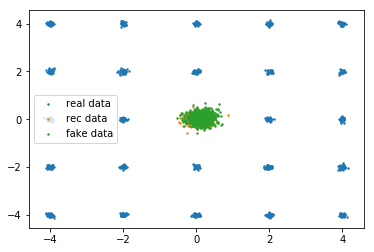

step 1000: KL: 2.107e+03, rec: -2.153e+02


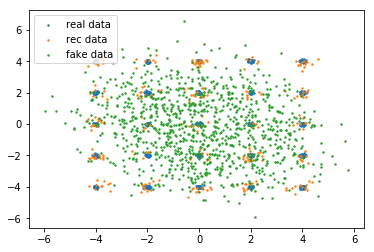

step 2000: KL: 1.532e+03, rec: -3.943e+02


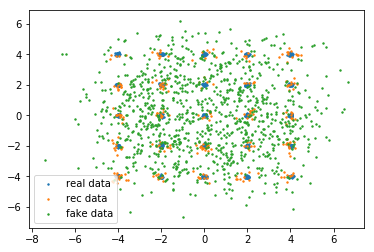

step 3000: KL: 1.529e+03, rec: -4.555e+02


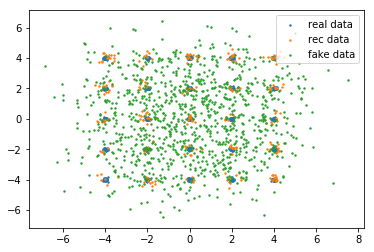

step 4000: KL: 1.513e+03, rec: -4.497e+02


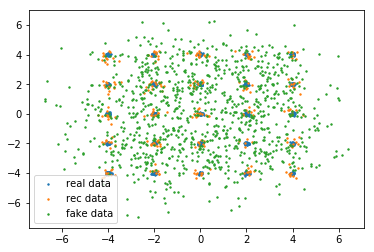

step 5000: KL: 1.523e+03, rec: -4.760e+02


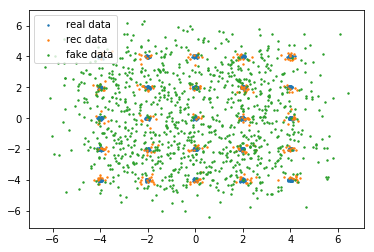

step 6000: KL: 1.524e+03, rec: -4.408e+02


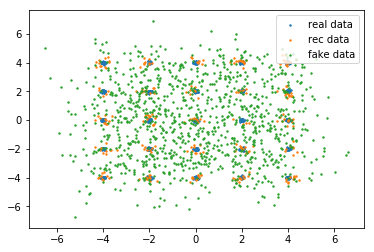

step 7000: KL: 1.505e+03, rec: -4.346e+02


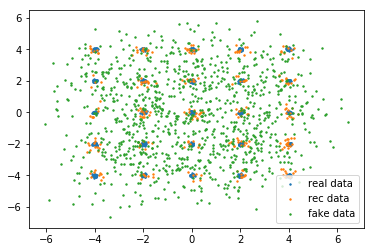

step 8000: KL: 1.492e+03, rec: -4.167e+02


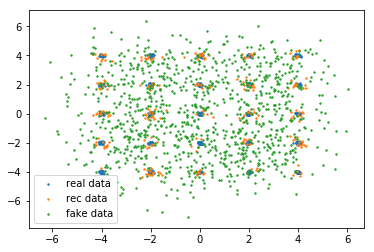

step 9000: KL: 1.497e+03, rec: -4.357e+02


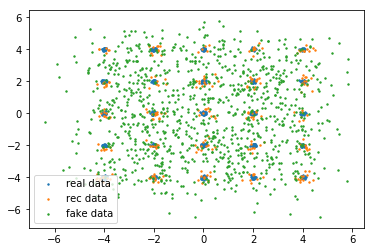

step 10000: KL: 1.511e+03, rec: -4.722e+02


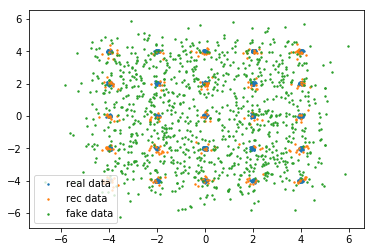

step 11000: KL: 1.509e+03, rec: -4.143e+02


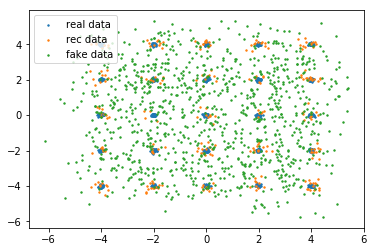

step 12000: KL: 1.476e+03, rec: -4.068e+02


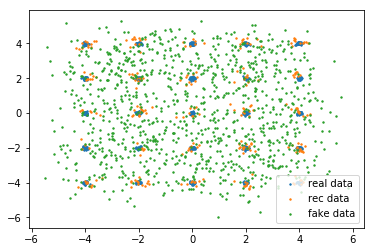

step 13000: KL: 1.469e+03, rec: -4.260e+02


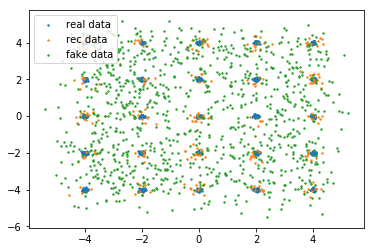

step 14000: KL: 1.455e+03, rec: -4.353e+02


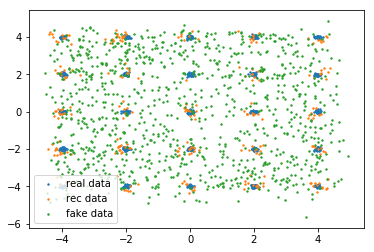

step 15000: KL: 1.410e+03, rec: -4.592e+02


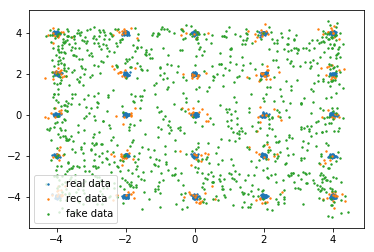

step 16000: KL: 1.381e+03, rec: -4.804e+02


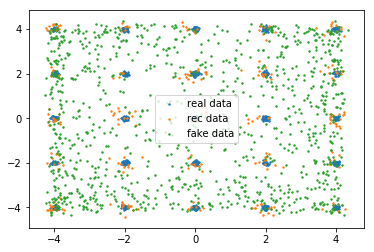

step 17000: KL: 1.372e+03, rec: -5.025e+02


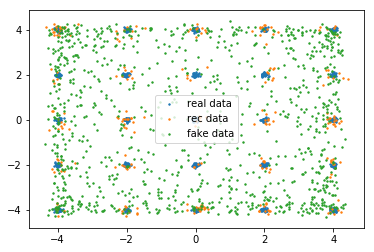

step 18000: KL: 1.371e+03, rec: -5.036e+02


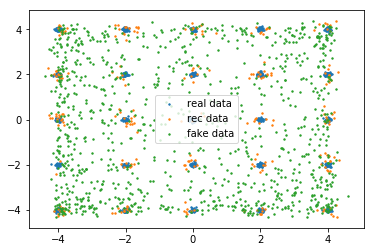

step 19000: KL: 1.390e+03, rec: -5.280e+02


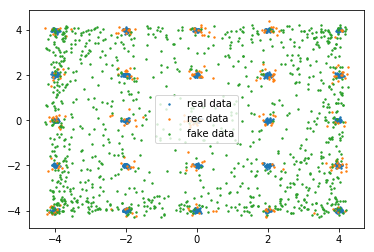

step 20000: KL: 1.378e+03, rec: -5.268e+02


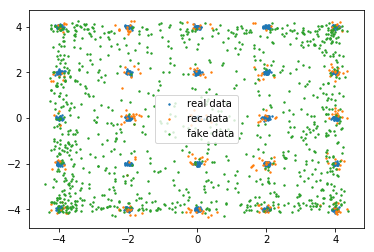

step 21000: KL: 1.376e+03, rec: -4.814e+02


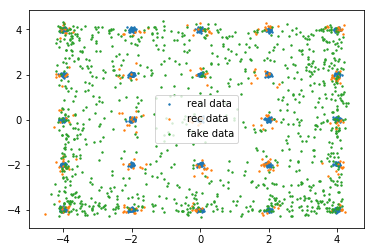

step 22000: KL: 1.361e+03, rec: -4.452e+02


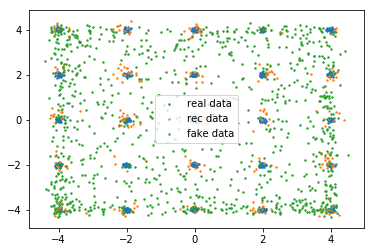

step 23000: KL: 1.390e+03, rec: -5.131e+02


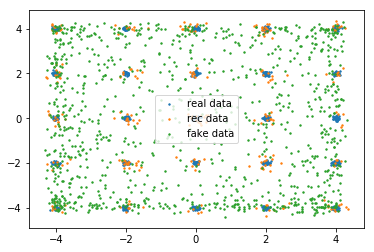

step 24000: KL: 1.365e+03, rec: -5.041e+02


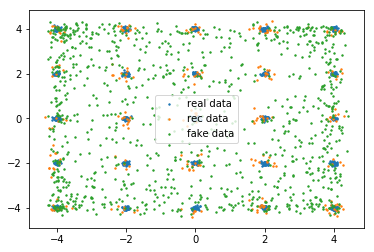

step 25000: KL: 1.339e+03, rec: -4.855e+02


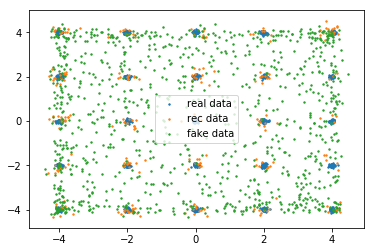

step 26000: KL: 1.377e+03, rec: -5.420e+02


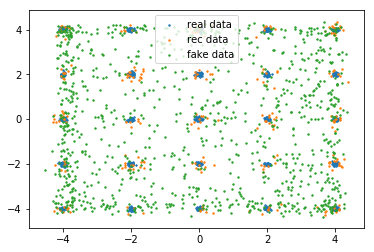

step 27000: KL: 1.356e+03, rec: -5.366e+02


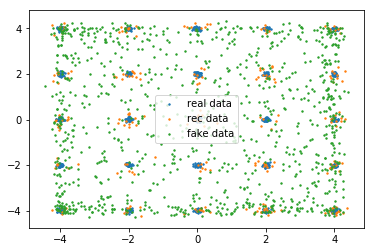

step 28000: KL: 1.349e+03, rec: -5.114e+02


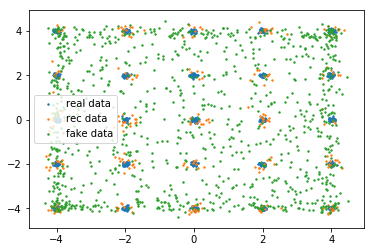

step 29000: KL: 1.371e+03, rec: -5.016e+02


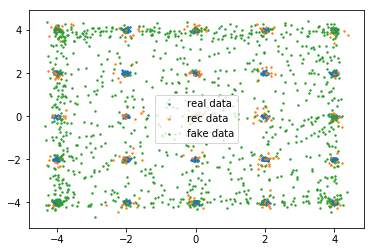

step 30000: KL: 1.367e+03, rec: -5.458e+02


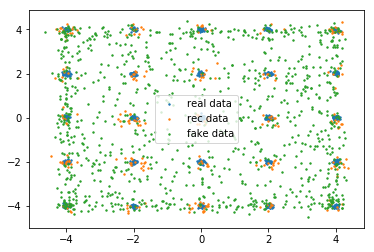

step 31000: KL: 1.370e+03, rec: -5.025e+02


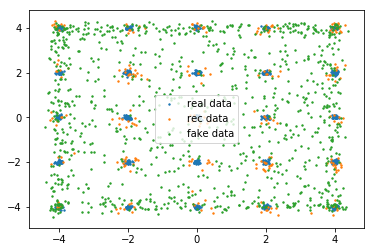

step 32000: KL: 1.367e+03, rec: -5.117e+02


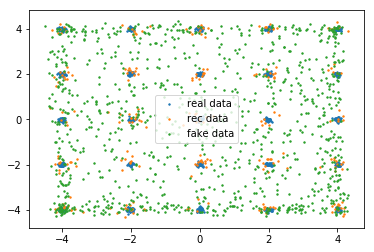

step 33000: KL: 1.356e+03, rec: -5.320e+02


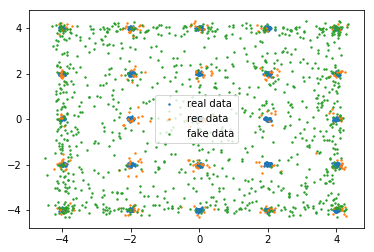

step 34000: KL: 1.347e+03, rec: -4.484e+02


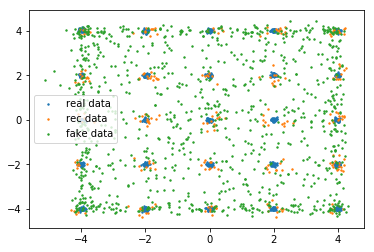

step 35000: KL: 1.345e+03, rec: -5.097e+02


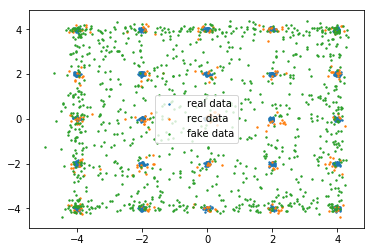

step 36000: KL: 1.354e+03, rec: -5.011e+02


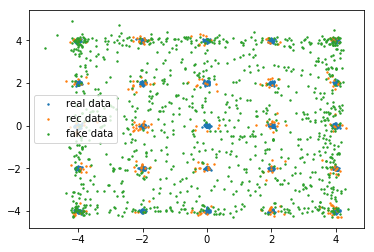

step 37000: KL: 1.357e+03, rec: -4.952e+02


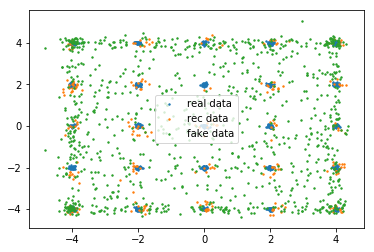

step 38000: KL: 1.365e+03, rec: -5.410e+02


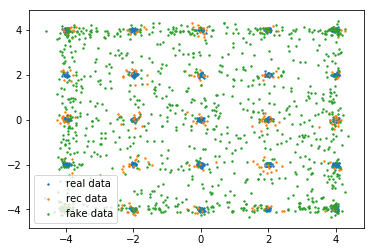

step 39000: KL: 1.348e+03, rec: -5.124e+02


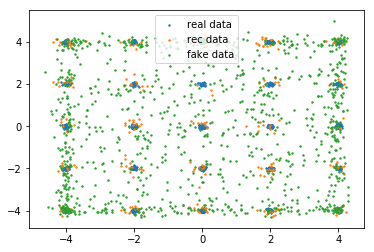

step 40000: KL: 1.359e+03, rec: -5.157e+02


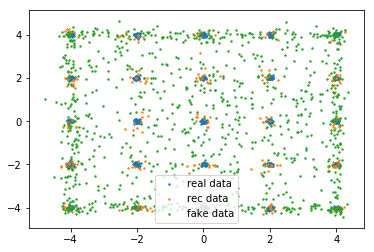

step 41000: KL: 1.339e+03, rec: -4.948e+02


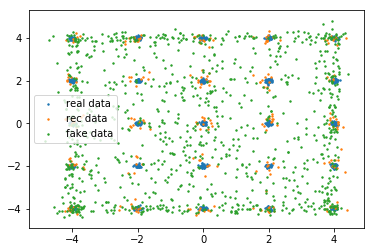

step 42000: KL: 1.342e+03, rec: -5.057e+02


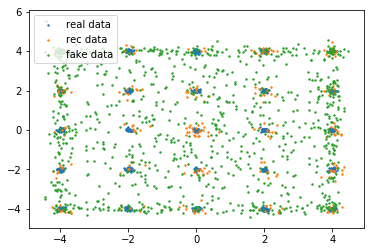

step 43000: KL: 1.330e+03, rec: -5.587e+02


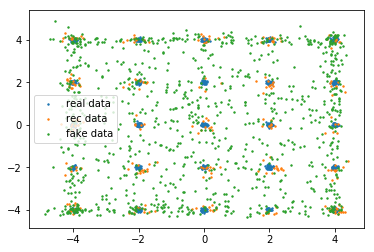

step 44000: KL: 1.341e+03, rec: -5.443e+02


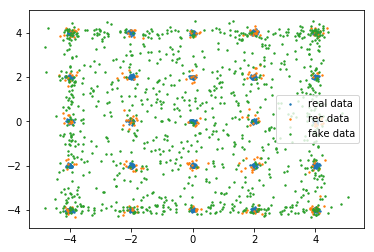

step 45000: KL: 1.336e+03, rec: -4.959e+02


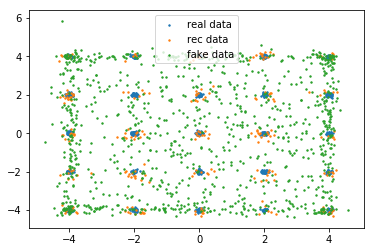

step 46000: KL: 1.333e+03, rec: -3.935e+02


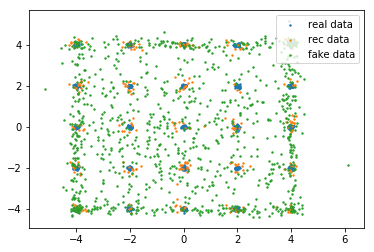

step 47000: KL: 1.335e+03, rec: -5.521e+02


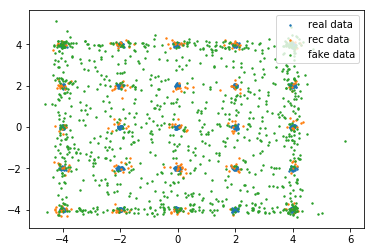

step 48000: KL: 1.329e+03, rec: -5.083e+02


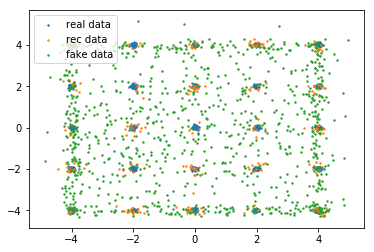

step 49000: KL: 1.333e+03, rec: -5.090e+02


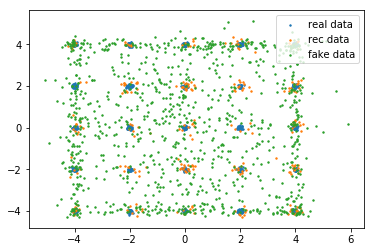

step 50000: KL: 1.328e+03, rec: -5.520e+02


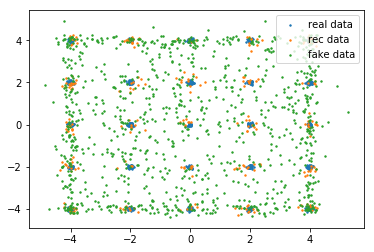

step 51000: KL: 1.319e+03, rec: -4.862e+02


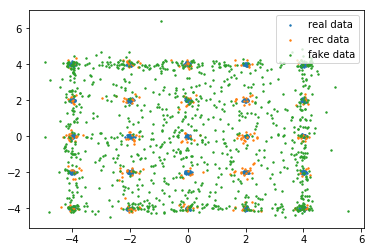

step 52000: KL: 1.311e+03, rec: -5.125e+02


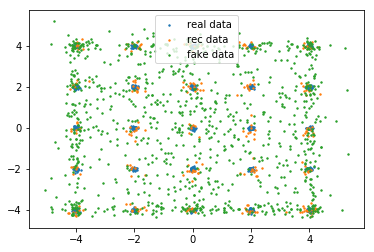

step 53000: KL: 1.321e+03, rec: -5.581e+02


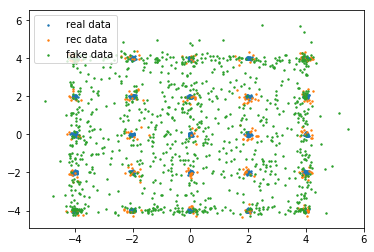

step 54000: KL: 1.309e+03, rec: -5.298e+02


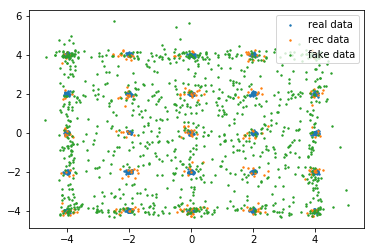

step 55000: KL: 1.314e+03, rec: -5.240e+02


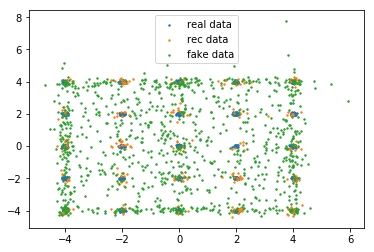

step 56000: KL: 1.302e+03, rec: -5.577e+02


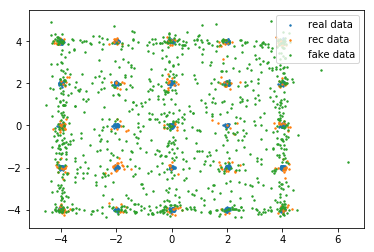

step 57000: KL: 1.312e+03, rec: -5.447e+02


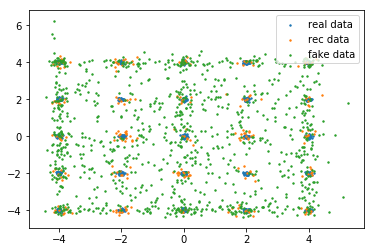

step 58000: KL: 1.283e+03, rec: -5.518e+02


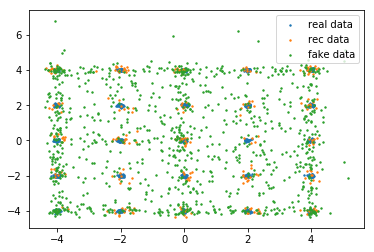

step 59000: KL: 1.314e+03, rec: -5.568e+02


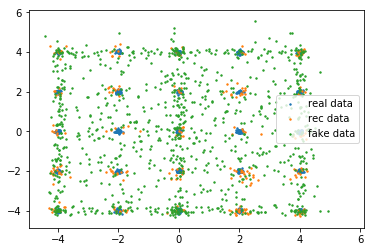

step 60000: KL: 1.280e+03, rec: -5.477e+02


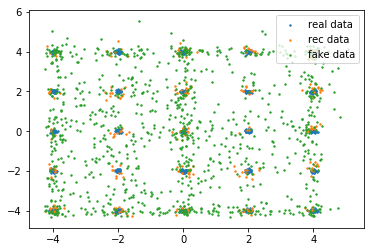

step 61000: KL: 1.276e+03, rec: -5.211e+02


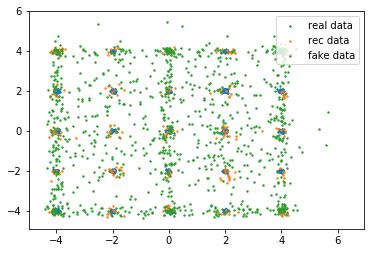

step 62000: KL: 1.270e+03, rec: -5.434e+02


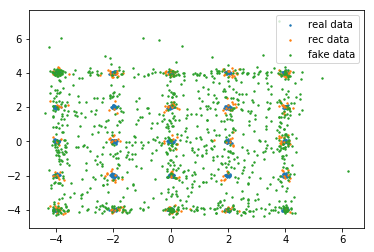

step 63000: KL: 1.318e+03, rec: -5.248e+02


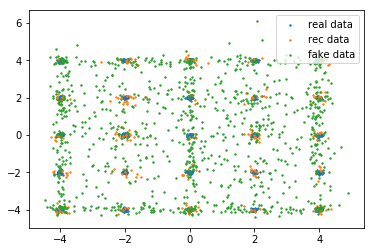

step 64000: KL: 1.266e+03, rec: -5.473e+02


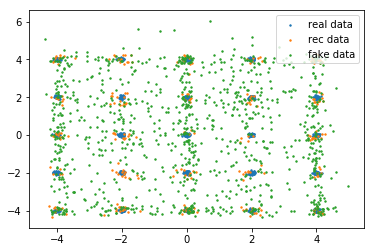

step 65000: KL: 1.253e+03, rec: -5.407e+02


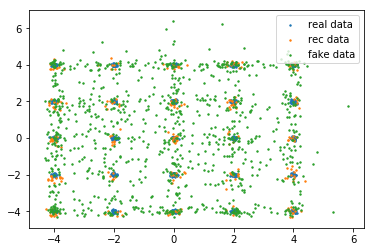

step 66000: KL: 1.227e+03, rec: -5.087e+02


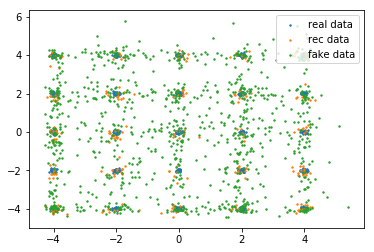

step 67000: KL: 1.215e+03, rec: -5.788e+02


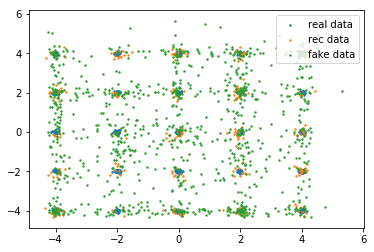

step 68000: KL: 1.200e+03, rec: -5.364e+02


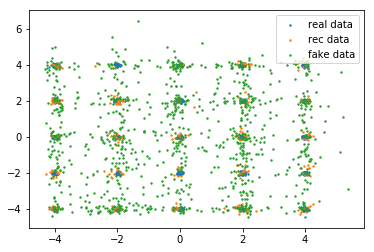

step 69000: KL: 1.177e+03, rec: -5.685e+02


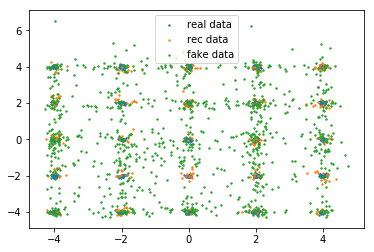

step 70000: KL: 1.189e+03, rec: -5.344e+02


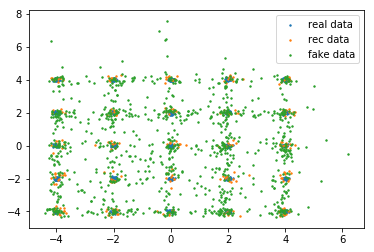

step 71000: KL: 1.145e+03, rec: -5.513e+02


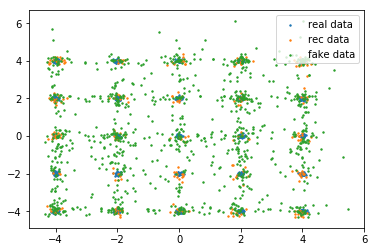

step 72000: KL: 1.174e+03, rec: -5.887e+02


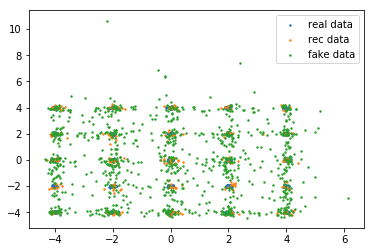

step 73000: KL: 1.177e+03, rec: -6.163e+02


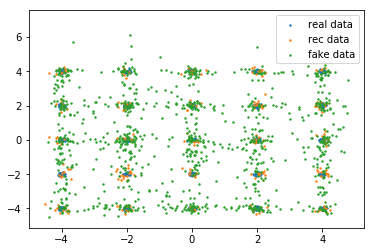

step 74000: KL: 1.155e+03, rec: -5.776e+02


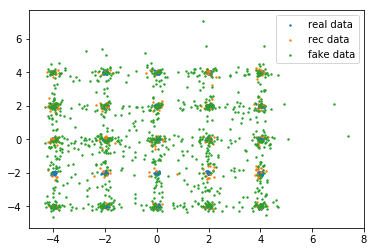

step 75000: KL: 1.150e+03, rec: -6.421e+02


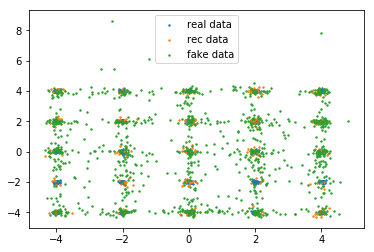

step 76000: KL: 1.174e+03, rec: -6.164e+02


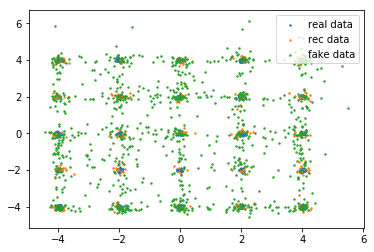

step 77000: KL: 1.151e+03, rec: -5.555e+02


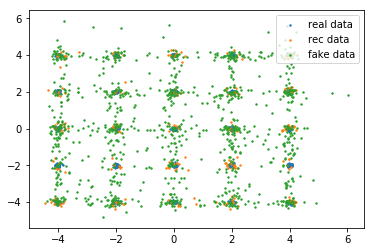

step 78000: KL: 1.177e+03, rec: -5.533e+02


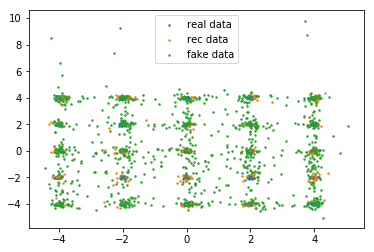

step 79000: KL: 1.152e+03, rec: -6.286e+02


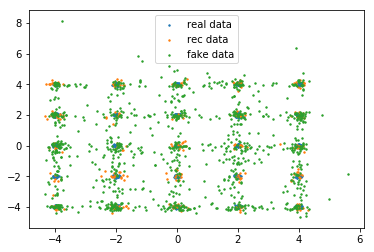

step 80000: KL: 1.162e+03, rec: -5.993e+02


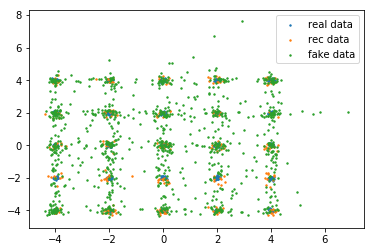

In [21]:
import numpy as np

# Total number of training iterations for the VAE
N_ITER = 80001
# Batch size to use
BATCHLEN = 256

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    # Compute here the DKL part of the VAE loss
    loss_kl = 0.5 * torch.sum(enc_logvar.exp() + enc_mu.pow(2) - 1 - enc_logvar)
    # Compute here the sample z, using Q12
    sample = torch.normal(torch.zeros(len(enc_mu), LATENT_N), 1.0)
    z = sample.mul(torch.exp(0.5 * enc_logvar)).add_(enc_mu)
    
    dec_mu, dec_logvar = decoder(z)
    # Compute here the second part of the VAE loss
    loss_rec = 0.5 * torch.sum(dec_logvar + (x - dec_mu).pow(2) / dec_logvar.exp() + np.log(2 * np.pi))
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i % 1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5 * dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q13: Try hardcoding $\sigma_\theta(z)$ to some small value (like 0.01) rather than allowing the decoder to learn it. What does it change?**

> Before hardcoding $\sigma_\theta$, the VAE can not minimize the reconstruction loss correctly. However its converges much better after fix  $\sigma_\theta$. In my opinion, the hardcoding changes the complexity of the optimization target. Once we fix the covariance matrix, the only thing we need to learn is the mean. Thus the decoder does a good job to find the good direction. Otherwise, it is very easy to get stucj in a saddle point.

**Q14: How do the power of encoder and decoder affect the overall training of the VAE?**

> The encoder decides the efficiency of the embedding. It is the basis of the VAE. The decoder decides the reconstruction ability of the VAE. 

**Q15: As a conclusion, how would you compare the advantages and shortcomings of GANs and VAEs?**

> * VAE: 

> **Advantage**: The losses of VAEs are comparable, which means that we can judge which VAE is better numerically from their losses. With the help of reconstruction loss, the decoder is guaranteed to learn the whole distribution $p_D$.

> **Shortcoming**: The main idea of VAE is to work in the latent space, which introduces many assumptions. It tend to produce blurry results relative to GAN.

> * GAN:

> **Advantage**: There's no strict assumptions. The generator and the discriminator can be trained iteratively. 

> **Shortcoming**: GAN is more difficult to train. The losses among different models are not comparable. The model may learn a part of the whole distribution.